Exercício baseado no problema publicado no Kaggle: https://www.kaggle.com/arnabbiswas1/microsoft-azure-predictive-maintenance?select=PdM_telemetry.csv

**Contexto:**
This an example data source which can be used for Predictive Maintenance Model Building. It consists of the following data:

- Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.
- Failure history: The failure history of a machine or component within the machine.
- Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
- Machine features: The features of a machine, e.g. engine size, make and model, location.


**Objetivo:**

**Proposta:**

Contato pelo Linkedin: https://bit.ly/3tsOnU3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
import itertools
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import skewnorm
from scipy.stats import shapiro
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore")
abs_path = os.getcwd()
dataset_csv_folder = 'dataset_csv'
dataset_csv_path = abs_path + '\\' + dataset_csv_folder
dataset_parquet_folder = 'dataset'
dataset_parquet_path = abs_path + '\\' + dataset_parquet_folder

# 1. Obtém o dataset através da API do Kaggle

In [2]:
erros_file = "PdM_errors"
failures_file = "PdM_failures"
machines_file = "PdM_machines"
maint_file = "PdM_maint"
telemetry_file = "PdM_telemetry"
zip_file = "microsoft-azure-predictive-maintenance.zip"

if not os.path.exists(dataset_parquet_path):
    os.makedirs(dataset_parquet_path)
if len(os.listdir(dataset_parquet_path)) == 0:
    """
    Obtém o dataset compactado em .zip, 
    extrai o arquivo .csv,
    deleta o arquivo .zip
    carrega o arquivo no jupyter,
    deleta o arquivo .csv,
    e gera um arquivo .parquet
    """
    !kaggle datasets download -d arnabbiswas1/microsoft-azure-predictive-maintenance
    if not os.path.exists(dataset_csv_path):
        os.makedirs(dataset_csv_path)
    with zipfile.ZipFile(zip_file,"r") as zip_ref:
        zip_ref.extractall(dataset_csv_path)
    os.remove(zip_file)
    for file in os.listdir(dataset_csv_path):
        dataset = pd.read_csv(dataset_csv_folder + "/" + file)
        dataset.to_parquet(dataset_parquet_folder + "/" + file.split('.')[0] + ".parquet", engine='pyarrow')
        os.remove(dataset_csv_folder + "/" + file)
    os.rmdir(dataset_csv_path)
else:
    print("Arquivos já existentes!")

datasets = {
    "errors" : pd.read_parquet(dataset_parquet_path + "/" + erros_file + ".parquet"),
    "failures" : pd.read_parquet(dataset_parquet_path + "/" + failures_file + ".parquet"),
    "machines" : pd.read_parquet(dataset_parquet_path + "/" + machines_file + ".parquet"),
    "maint" : pd.read_parquet(dataset_parquet_path + "/" + maint_file + ".parquet"),
    "telemetry" : pd.read_parquet(dataset_parquet_path + "/" + telemetry_file + ".parquet"),
}

print("Arquivos carregados.")

Arquivos já existentes!
Arquivos carregados.


In [3]:
print("Tamanho dos datasets:")
for key in datasets:
    print("\t- {:<10}: {:}".format(key.capitalize(), datasets[key].shape))

Tamanho dos datasets:
	- Errors    : (3919, 3)
	- Failures  : (761, 3)
	- Machines  : (100, 3)
	- Maint     : (3286, 3)
	- Telemetry : (876100, 6)


**Tabela 1 - Histórico de log de erros - 5 primeiros elementos**

In [4]:
datasets["errors"].head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [5]:
print("Data do dado mais antigo de log de erro: {}\nData do dado mais novo de log de erro: {}".format(datasets["errors"].iloc[:,:1].min()[0], datasets["errors"].iloc[:,:1].max()[0]))

Data do dado mais antigo de log de erro: 2015-01-01 06:00:00
Data do dado mais novo de log de erro: 2016-01-01 05:00:00


**Tabela 2 - Histórico de substituição de componentes devido a falhas - 5 primeiros elementos**

In [6]:
datasets["failures"].head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [7]:
print("Data do dado mais antigo de substituição de componente: {}\nData do dado mais novo de substituição de componente: {}".format(datasets["failures"].iloc[:,:1].min()[0], datasets["failures"].iloc[:,:1].max()[0]))

Data do dado mais antigo de substituição de componente: 2015-01-02 03:00:00
Data do dado mais novo de substituição de componente: 2015-12-31 06:00:00


**Tabela 3 - Inventário de máquinas - 5 primeiros elementos**

In [8]:
datasets["machines"].head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


**Tabela 4 - Histórico de manutenções agendadas e não-agendadas correspondentes à inspeções regulares de componentes e falhas - 5 primeiros elementos**

In [9]:
datasets["maint"].head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [10]:
print("Data do dado mais antigo de manutenção: {}\nData do dado mais novo de manutenção: {}".format(datasets["maint"].iloc[:,:1].min()[0], datasets["maint"].iloc[:,:1].max()[0]))

Data do dado mais antigo de manutenção: 2014-06-01 06:00:00
Data do dado mais novo de manutenção: 2016-01-01 06:00:00


**Tabela 5 - Dados históricos de medições coletadas das 100 máquinas em tempo real - média dos dados de cada hora - 5 primeiros elementos**

In [11]:
datasets["telemetry"].head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [12]:
print("Data do dado mais antigo de telemetria: {}\nData do dado mais novo de telemetria: {}".format(datasets["telemetry"].iloc[:,:1].min()[0], datasets["telemetry"].iloc[:,:1].max()[0]))

Data do dado mais antigo de telemetria: 2015-01-01 06:00:00
Data do dado mais novo de telemetria: 2016-01-01 06:00:00


# 2. Análise Exploratória dos Dados

**análise:** através dos resultados "false" obtidos abaixo, foi provado que:
- Todos os elementos possuem todos os dados, portanto não se faz necessário a remoção de nenhum deles da base de dados, bem como não se faz necessário utilizar nenhuma técnica de preenchimento de dado (ex.: interpolação, média, moda e etc.).
- Não há colunas com excesso de dados nulos, portanto, se for necessário eliminar alguma coluna, não será por este motivo, mas sim por algum outro como baixa correlação com a variável de resposta.

**Contagem de dados nulos por coluna**

In [13]:
datasets["errors"].isnull().values.any(), datasets["failures"].isnull().values.any(), datasets["machines"].isnull().values.any(), datasets["maint"].isnull().values.any(), datasets["telemetry"].isnull().values.any()

(False, False, False, False, False)

**análise:** os gráficos de distribuição da tabela de telemetria (Tabela 5) provam logo abaixo que se faz necessário a normalização das variáveis explicativas. Já os box plots abaixo mostram que existem alguns outliers na tabela de telemetria (Tabela 5).

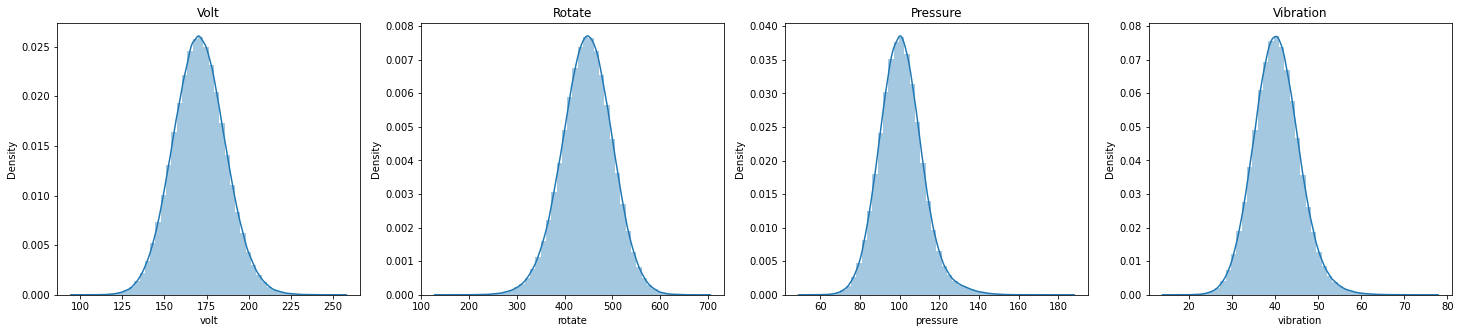

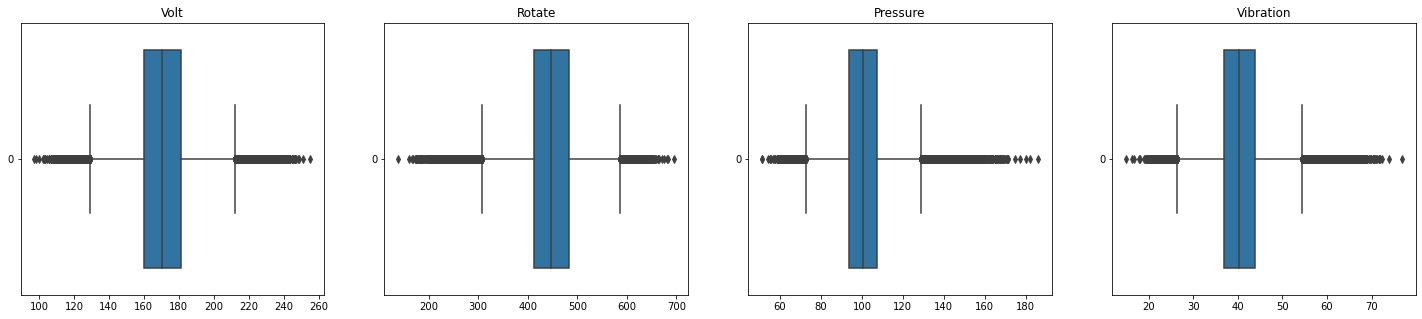

In [14]:
x = datasets["telemetry"].iloc[:,2:]

plt.figure(figsize=(25,5))
for count, column in enumerate(x.columns):
    plt.subplot(1, len(x.columns), count+1)
    plt.title(column.capitalize())
    plt.subplot(sns.distplot(x[column]))
    
plt.figure(figsize=(25,5))
for count, column in enumerate(x.columns):
    plt.subplot(1, len(x.columns), count+1)
    plt.title(column.capitalize())
    plt.subplot(sns.boxplot(data=x[column], orient="h"))

plt.show()
plt.close()

**Objetivo: cruzar as duas bases abaixo com as outras bases do dataset (ex.: telemetria) procurando por um padrão de comportamento das falhas**

**Quantidade de falhas por dia - Out./Nov. 2015**

<AxesSubplot:xlabel='Dia', ylabel='Quantidade de Falhas'>

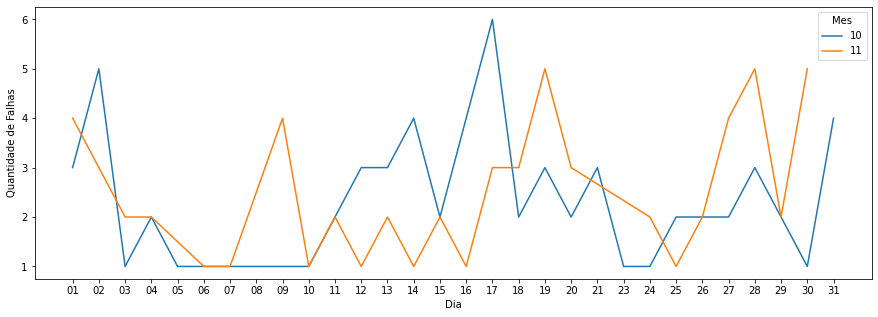

In [15]:
plt.figure(figsize=(15,5))
falhas = datasets["failures"].groupby("datetime").size().reset_index(name='Quantidade de Falhas')
falhas.columns = ['Data das Falhas', 'Quantidade de Falhas']

ano_mes_dia = []
[ano_mes_dia.append(falhas.iat[i,0].split()[0].split("-")) for i in range(len(falhas))]
ano_mes_dia_np = np.array(ano_mes_dia).T
falhas["Ano"], falhas["Mes"], falhas["Dia"] = ano_mes_dia_np[0], ano_mes_dia_np[1], ano_mes_dia_np[2]
sns.lineplot(data=falhas.query("Mes in ['11','10'] & Ano in ['2015']").sort_values(by=['Dia', 'Mes']), x="Dia", y="Quantidade de Falhas", hue="Mes")

**Quantidade de logs de erro por dia - Out./Nov. 2015**

<AxesSubplot:xlabel='Dia', ylabel='Quantidade de Logs de Erros'>

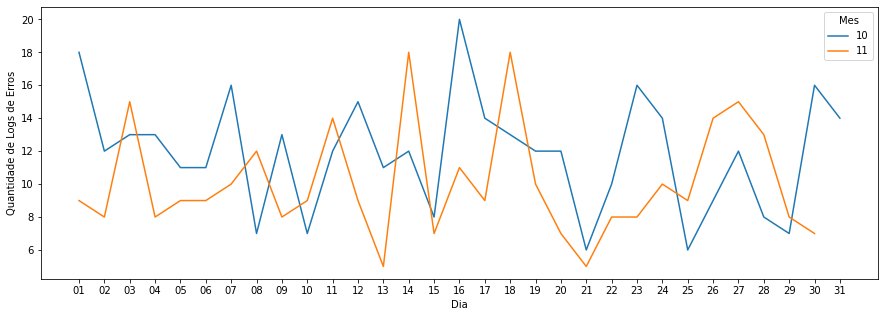

In [16]:
plt.figure(figsize=(15,5))
erros = datasets["errors"].groupby("datetime").size().reset_index(name='Quantidade de Logs de Erros')
erros.columns = ['Data dos Logs de Erros', 'Quantidade de Logs de Erros']
ano_mes_dia = []
[ano_mes_dia.append(erros.iat[i,0].split()[0].split("-")) for i in range(len(erros))]
ano_mes_dia_np = np.array(ano_mes_dia).T
erros["Ano"], erros["Mes"], erros["Dia"] = ano_mes_dia_np[0], ano_mes_dia_np[1], ano_mes_dia_np[2]
erros = erros.groupby(by=['Ano', 'Mes', 'Dia'])['Quantidade de Logs de Erros'].sum().reset_index()
sns.lineplot(data=erros.query("Mes in ['11','10'] & Ano in ['2015']").sort_values(by=['Dia', 'Mes']), x="Dia", y="Quantidade de Logs de Erros", hue="Mes")

In [17]:
!jupyter nbconvert --to html --output "notebook_file" "Projeto - IoT.ipynb" --no-input

[NbConvertApp] Converting notebook Projeto - IoT.ipynb to html
[NbConvertApp] Writing 782828 bytes to notebook_file.html
